In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import json
import warnings
warnings.filterwarnings("ignore")

In [28]:
node_type = 'compute_haswell'
interval = 1

# Step 1. Preprocess Machine Events

In [29]:
me = pd.read_csv('../datasets/machine_events/compute_haswell.csv')
me['EVENT_TIME'] = pd.to_datetime(me['EVENT_TIME'])
me.sort_values(by=['EVENT_TIME'], inplace=True)

# Step 2. Preprocess Lease Info Data

In [30]:
leases = pd.read_csv('../datasets/lease_info/compute_haswell.csv')

In [31]:
def process_lease_data(df):
    df['start_on'] = pd.to_datetime(df['start_on'])
    df['deleted_at'] = pd.to_datetime(df['deleted_at'])
    df['end_on'] = pd.to_datetime(df['end_on'])
    for i in df.index:
        deleted_at = df.iloc[i]['deleted_at']
        end_on = df.iloc[i]['end_on']
        if deleted_at and deleted_at < end_on:
            df.at[i, 'end_on'] = deleted_at  # set the end_on time to smaller(end_on, deleted_at) since users may delete the lease before ending
    df.sort_values(by=['start_on'], inplace=True)
    return df
    
leases = process_lease_data(leases)

# Step 3. Trace In-use and Available Resources

In [32]:
def trace_in_use(df, slot):
    tracer = []
    df = df[~df['status'].isin(['error', 'pending'])]
    for index, row in df.iterrows():
        if row['start_on'] < row['end_on']:  # no resource is allocated if the lease end time is earlier than the start time
            tracer.append({
                'timestamp': row['start_on'],
                'in_use': row['node_cnt']
            })
            tracer.append({
                'timestamp': row['end_on'],
                'in_use': -row['node_cnt']
            })

    tracer = pd.DataFrame(tracer)
    tracer.sort_values(by=['timestamp'], inplace=True)
    tracer['in_use'] = np.cumsum(tracer['in_use'].to_list())
    tracer.set_index(['timestamp'], inplace=True)
    tracer = tracer.resample('%dH' % slot).max().fillna(0)
    return tracer

lease_tracer = trace_in_use(leases, interval)

In [33]:
def trace_av(df, slot):
    tracer = []
    unique_host = {}
    for index, row in df.iterrows():
        ## ???? UPDATE执行的是什么操作，是否自动enable节点
        if row['EVENT'] in ['ENABLE', 'UPDATE'] and row['HOST_NAME (PHYSICAL)'] not in unique_host:
            unique_host.update({row['HOST_NAME (PHYSICAL)']: row['EVENT']})
            tracer.append({
                'timestamp': row['EVENT_TIME'],
                'available': 1
            })
        elif row['EVENT'] in ['DISABLE'] and row['HOST_NAME (PHYSICAL)'] in unique_host:
            del unique_host[row['HOST_NAME (PHYSICAL)']]
            tracer.append({
                'timestamp': row['EVENT_TIME'],
                'available': -1
            })

    tracer = pd.DataFrame(tracer)
    tracer.sort_values(by=['timestamp'], inplace=True)
    tracer['available'] = np.cumsum(tracer['available'].to_list())
    tracer.set_index(['timestamp'], inplace=True)
    tracer = tracer.resample('%dH' % slot).max().fillna(method='ffill')
    return tracer

me_tracer = trace_av(me, interval)

In [34]:
tracer = me_tracer.join(lease_tracer)

In [35]:
def plot_trace(data, fields):
    fig = go.Figure()
    for f in fields:
        fig.add_trace(go.Scatter(x=data.index, y=data[f], mode='lines', name=f))
    fig.update_layout(showlegend=True)

    fig.update_layout(
        width=1000,
        height=500,
        margin=dict(l=20, r=20, t=20, b=20),
        paper_bgcolor="LightSteelBlue",
    )
    fig.show()

In [36]:
plot_trace(tracer, ['available', 'in_use'])

In [37]:
tracer['rate'] = 100*tracer['in_use']/tracer['available']

<AxesSubplot:xlabel='timestamp'>

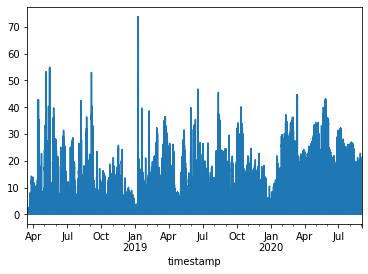

In [38]:
tracer['rate'].plot()

In [39]:
print('Mean:', tracer['rate'].mean())
print('Std:', tracer['rate'].std())
print('Percentile:', tracer['rate'].quantile([0.5, 0.8, 0.9, 0.95]))

Mean: 11.33640725780458
Std: 10.168797909198702
Percentile: 0.50     9.965636
0.80    20.901639
0.90    25.429553
0.95    30.041152
Name: rate, dtype: float64


<AxesSubplot:>

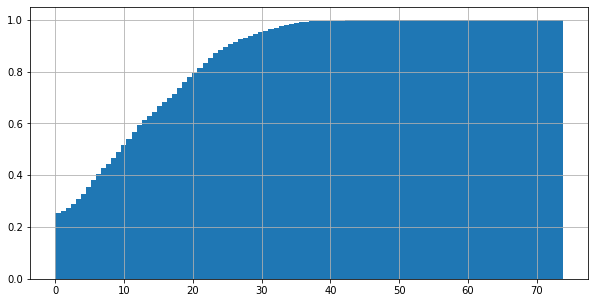

In [40]:
tracer['rate'].hist(bins=100, cumulative=True, density=1, figsize=(10, 5))